In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import json
from matplotlib import colormaps
import re
import io


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# This code is used to plot the data from the FE tester for the CV
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

%config InlineBackend.figure_format = 'retina' # For high resolution figures in Jupyter Notebook
#%matplotlib widget

In [8]:
# Function to determine the device ID from the filename
#--------------------------------------------------------------------------------------------------------------
def map_filenames_to_device_id(filename, id_base):

    pattern = re.compile(r'_ (\d+) (\d+)')
    
    if filename.endswith('.csv'):
        match = pattern.search(filename)
        if match:
            x = int(match.group(1))
            y = int(match.group(2))
            device_id = id_base + x + 75 * y
            return f"{device_id:03d}"
        else:
            raise ValueError(f"Filename '{filename}' does not match expected pattern.")
    else:
        raise ValueError(f"Filename '{filename}' does not end with .csv.")
    


# Function to calculate the surface area of the Baigol Octogone device based on its ID
#--------------------------------------------------------------------------------------------------------------
def BAIGOL_OCTOGONE_DEVICE_SURFACE_AREA(device_id):
    """
    Returns the surface area of the device based on its ID.
    """

    # Create base list from 0 to 14 and so on
    ID_01 = list(range(0, 15))
    ID_02 = list(range(15, 30))
    ID_03 = list(range(30, 45))
    ID_04 = list(range(45, 60))
    ID_05 = list(range(60, 75))

    # Repeat pattern 9 times: each time offset by 75 * i
    for i in range(1, 10):
        for j in range(15):
            ID_01 += [i * 75 + j]
            ID_02 += [i * 75 + j + 15]
            ID_03 += [i * 75 + j + 30]
            ID_04 += [i * 75 + j + 45]
            ID_05 += [i * 75 + j + 60]

    if device_id in ID_01:
        return 14521.8
    elif device_id in ID_02:
        return 10215.1
    elif device_id in ID_03:
        return 6664
    elif device_id in ID_04:
        return 3868
    elif device_id in ID_05:
        return 1828.44
    else:
        raise ValueError(f"Device ID {device_id} not recognized. Please check the input value.")
    


# List of frequencies used durging the C-V sweep
#--------------------------------------------------------------------------------------------------------------

def FREQUENCY_LIST(Data_frame):

    frequency_raw = pd.to_numeric(Data_frame['Frequency'], errors='coerce')
    frequency_list = []

    for x in frequency_raw:
        if x not in frequency_list:
            frequency_list.append(x)
    
    return frequency_list
    
    

# Commpute the moving average of a list
#--------------------------------------------------------------------------------------------------------------
def moving_average(x, window_size):
    x = np.array(x)  # <-- conversion automatique, safe pour Series, listes ou arrays
    return np.convolve(x, np.ones(window_size)/window_size, mode='same')


In [9]:
# Set the path to the data file
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

file_path = r'E:\Nextcloud\00 - ViFOX\05 - Data\02 - FE tester\NASA_SL_ALE_10\Capacitance measurement'
file_name = 'NASA_SL_ALE_10_ID_060.dat'
Device_ID = 60

full_path = os.path.join(file_path, file_name)

# Extract the last folder name from the file path
last_folder = os.path.basename(os.path.dirname(file_path))
print(last_folder)  # ➜ "Essai1"

# Séparer nom et extension
base_name = os.path.splitext(file_name)[0]
print(base_name)  # ➜ NASA_SL_ALE_10_ID_095
Device_area = BAIGOL_OCTOGONE_DEVICE_SURFACE_AREA(Device_ID)
print(Device_area) 

NASA_SL_ALE_10
NASA_SL_ALE_10_ID_060
1828.44


In [10]:
# Read the file as plain text and split by "Table X"
# ----------------------------------------------------------------------------------------------------------------------------------

with open(full_path, 'r', encoding='utf-8', errors='ignore') as f:
    content = f.read()

tables_raw = re.split(r'Table \d+', content)
dataframes = []
table_infos = []  # Pour stocker freq et amplitude

for table in tables_raw:
    if 'Bias [V]' in table:
        lines = table.strip().splitlines()

        # 1. Extraire SsFrequency et SsAmplitude
        freq = None
        ampl = None
        for line in lines:
            freq_match = re.search(r'SsFrequency\s*\[Hz\]:\s*([\d.eE+-]+)', line)
            ampl_match = re.search(r'SsAmplitude\s*\[V\]:\s*([\d.eE+-]+)', line)
            if freq_match:
                freq = float(freq_match.group(1))
            if ampl_match:
                ampl = float(ampl_match.group(1))
            if freq and ampl:
                break  # On sort dès qu'on a les deux

        # 2. Trouver les données (lignes tabulaires)
        header_index = None
        for i, line in enumerate(lines):
            if 'Bias [V]' in line:
                header_index = i
                break

        if header_index is not None:
            try:
                df = pd.read_csv(
                    io.StringIO('\n'.join(lines[header_index:])),
                    sep='\t',
                    engine='python'
                )
                dataframes.append(df)
                table_infos.append({'frequency_Hz': freq, 'amplitude_V': ampl})
            except Exception as e:
                print("Erreur dans une table :", e)

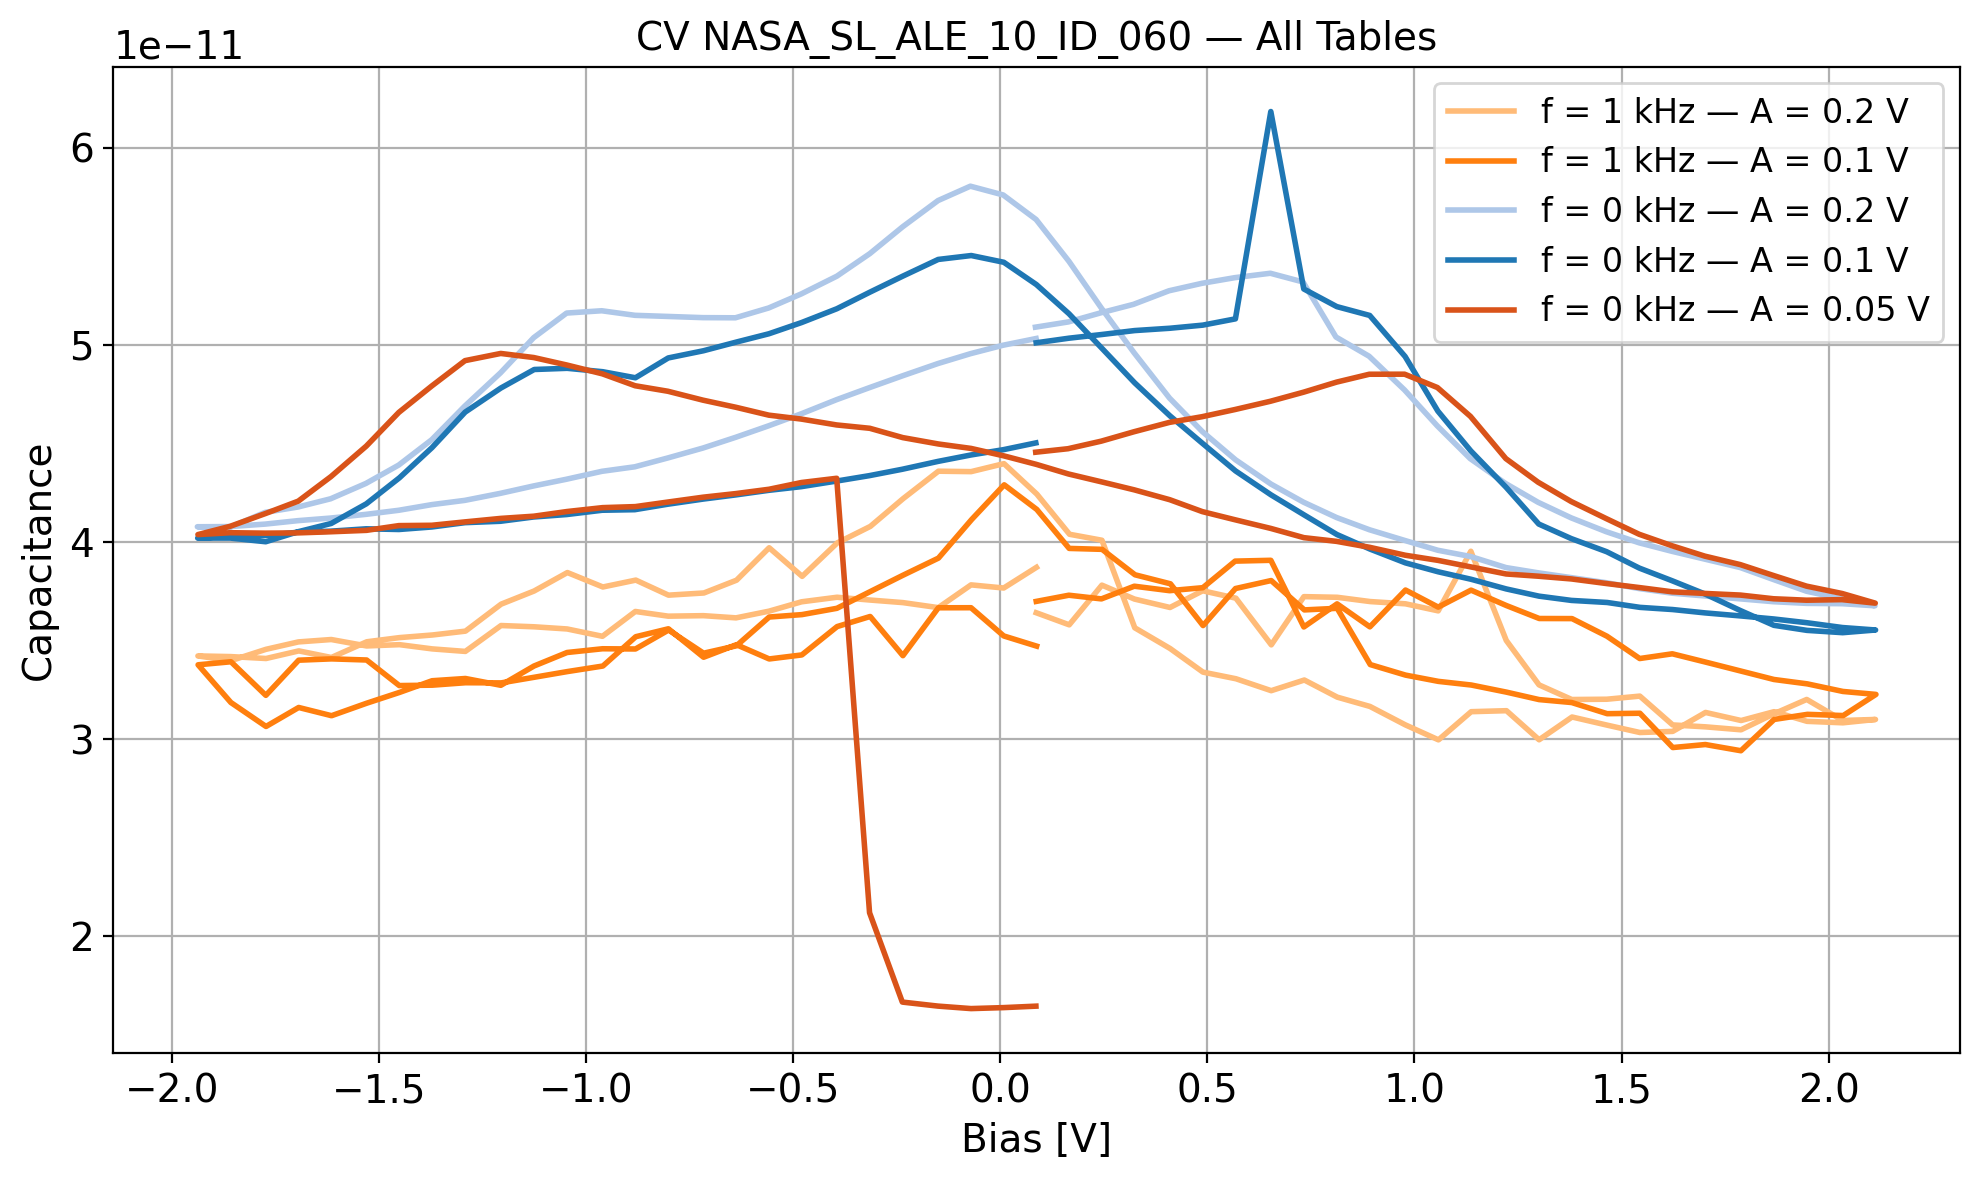

In [11]:
# Plot each table individually with its own color on a single plot
# ----------------------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(10, 6))

# Mettre à jour les paramètres de taille de police pour axes et titres
plt.rcParams.update({
    'axes.labelsize': 14,    # Taille des labels d'axe
    'axes.titlesize': 14,    # Taille du titre
    'xtick.labelsize': 14,   # Taille des graduations en x
    'ytick.labelsize': 14,   # Taille des graduations en y
    'legend.fontsize': 12    # Taille de la légende
})

# Prepare a colormap for consistent coloring of each curve
cmap = colormaps['tab20']
colors = [(0.8500, 0.3250, 0.0980)]
for i in range(len(dataframes) - 1):
    colors.insert(0,cmap(i))
color_index = 0

for i, (df, info) in enumerate(zip(dataframes, table_infos)):
    try:
        bias = pd.to_numeric(df['Bias [V]'], errors='coerce')
        cap = pd.to_numeric(df['C [F]'], errors='coerce')
        mask = ~bias.isna() & ~cap.isna()


        label_str = f"f = {info['frequency_Hz'] / 1e3:.0f} kHz — A = {info['amplitude_V']} V"

        color_plot = colors[color_index]

        plt.plot(bias[mask], cap[mask], label=label_str,color = color_plot, linewidth=2)
        color_index += 1


        
    except KeyError:
        print(f"Colonnes manquantes dans Table {i+1}")

plt.xlabel('Bias [V]')
plt.ylabel('Capacitance')

plt.title(f'CV {base_name} — All Tables')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

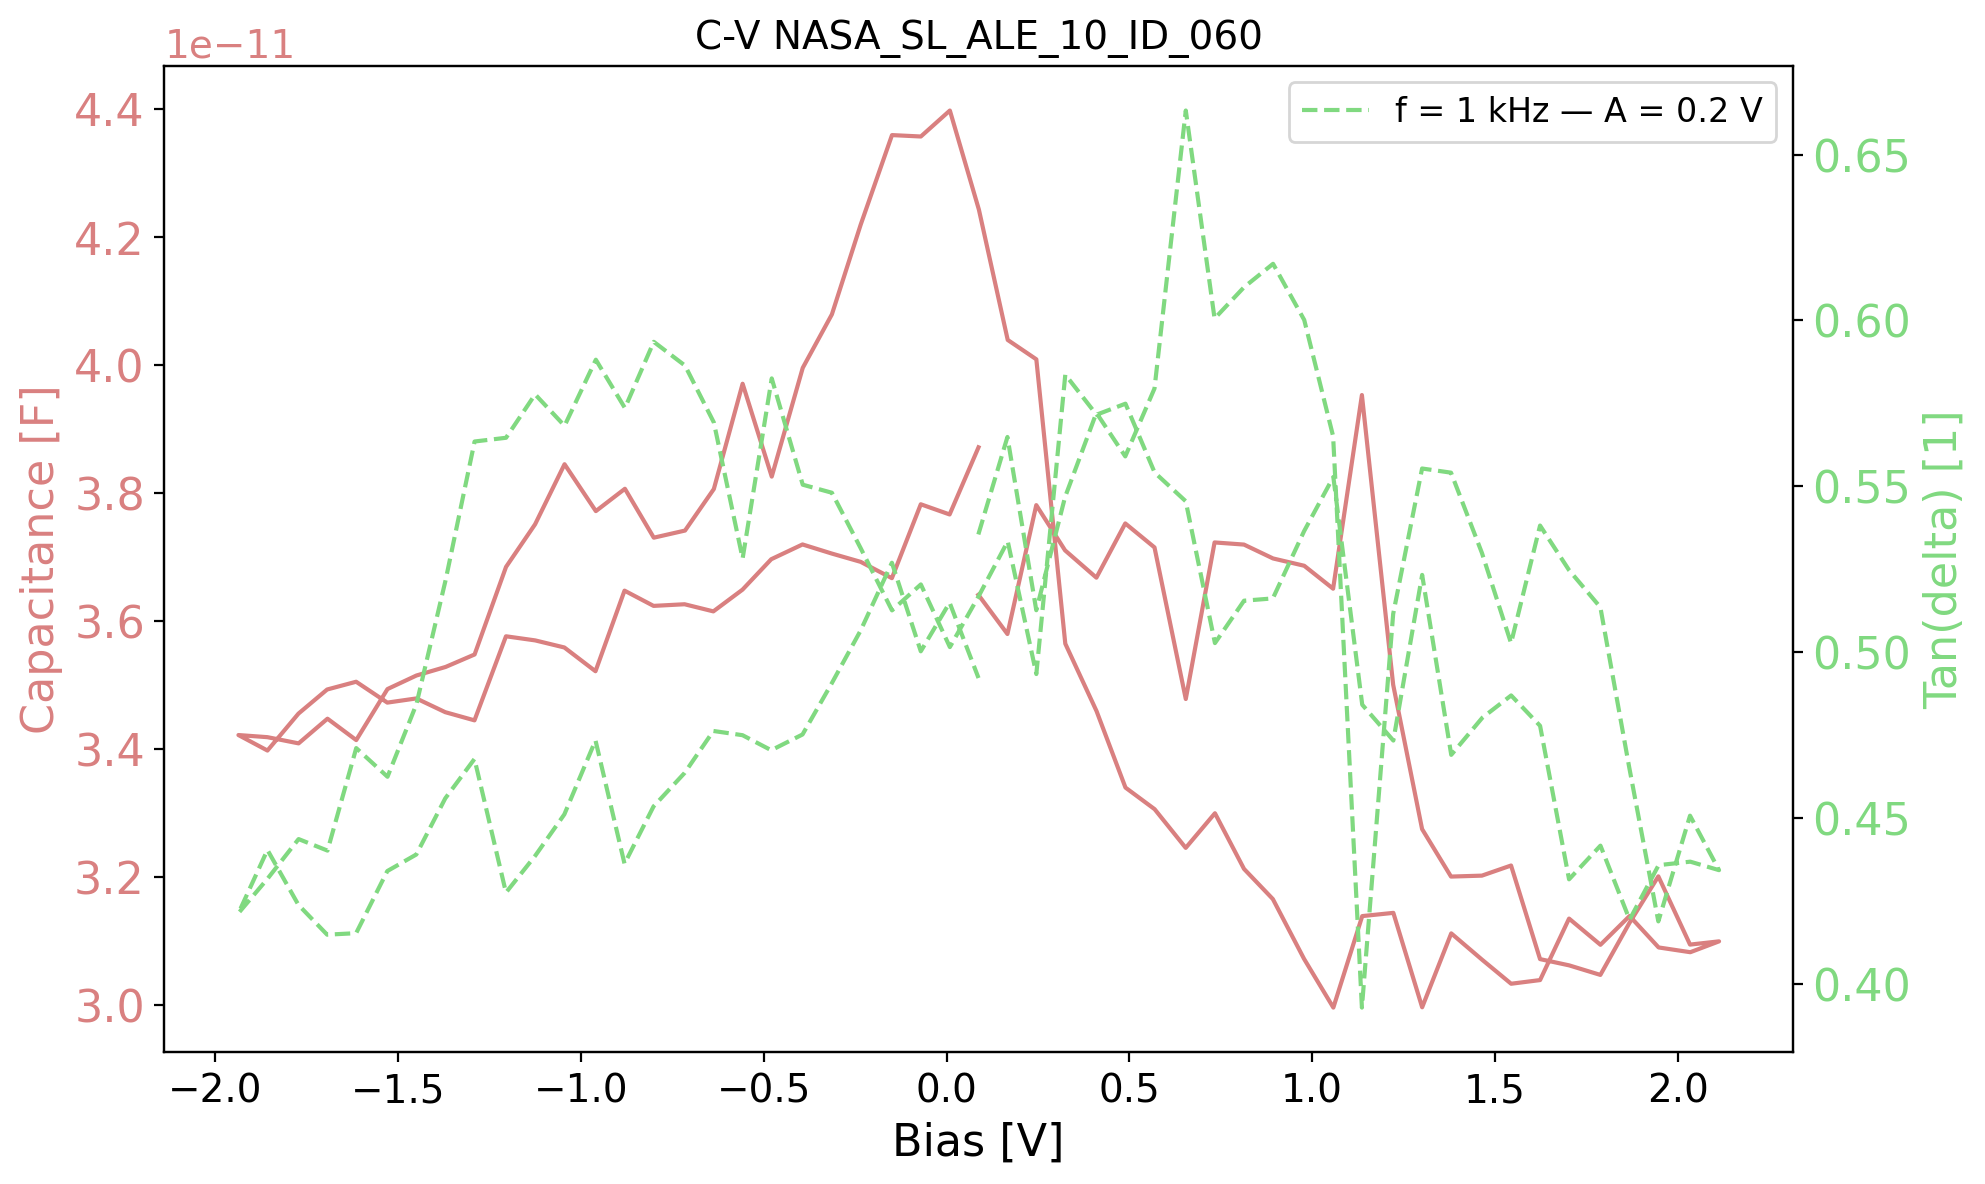

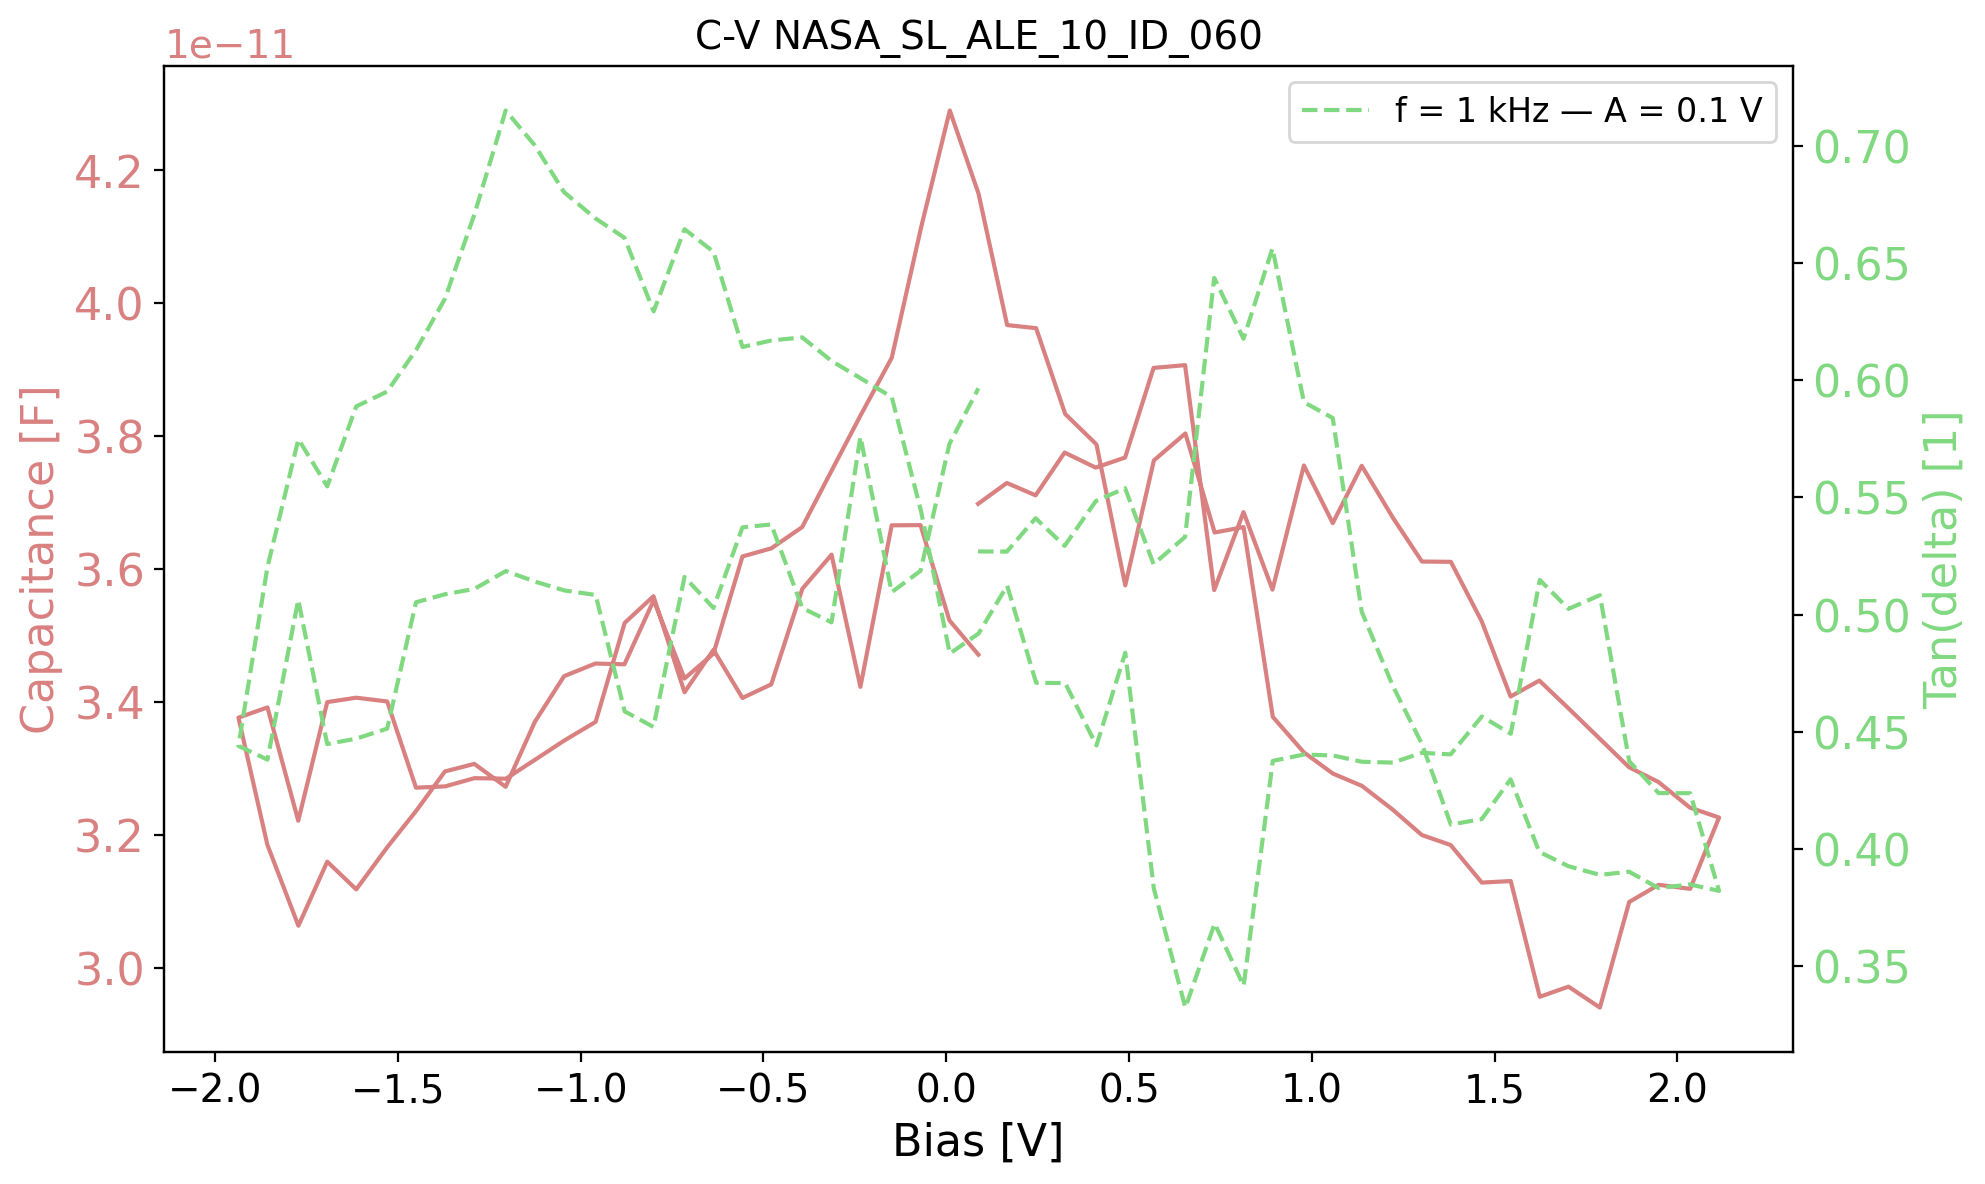

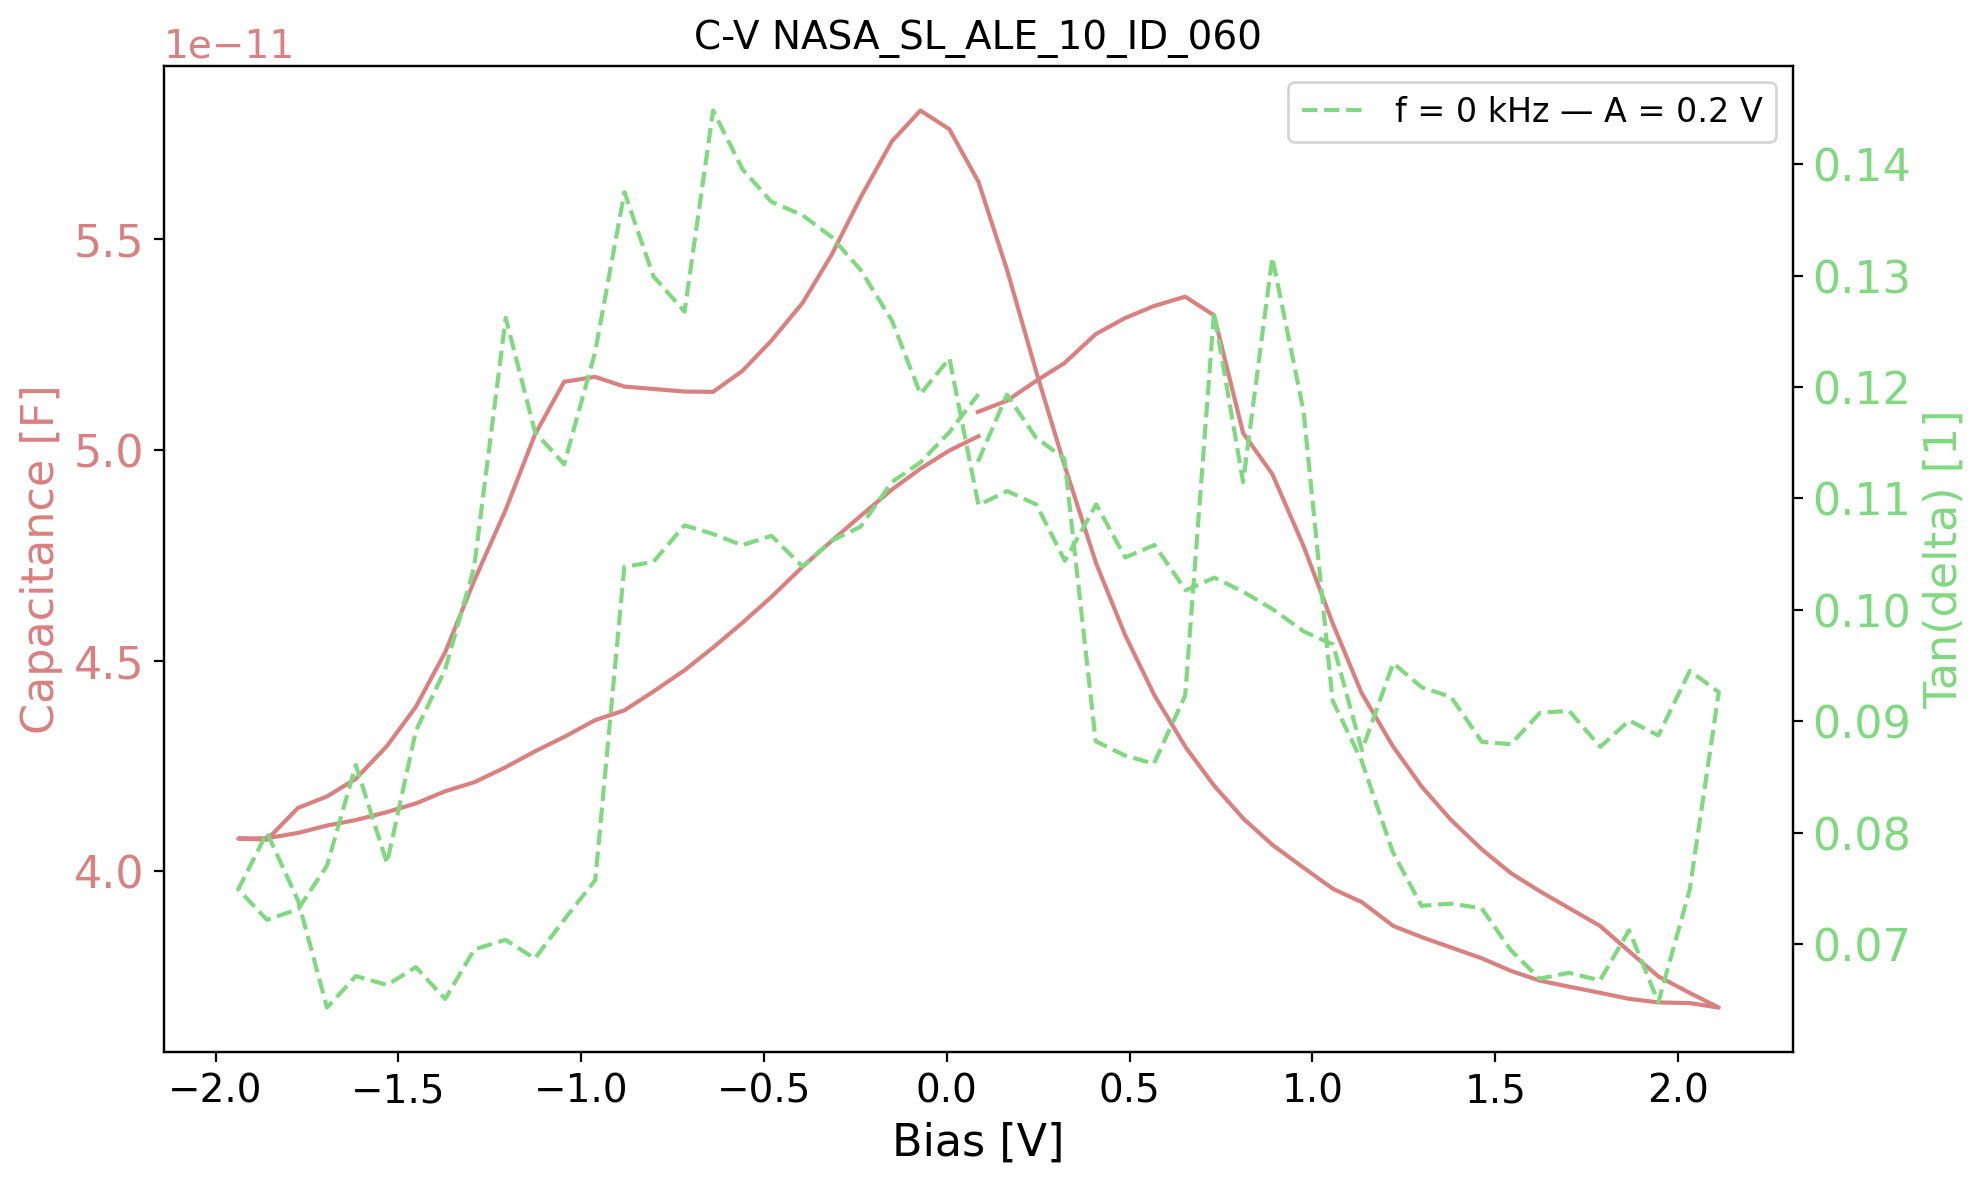

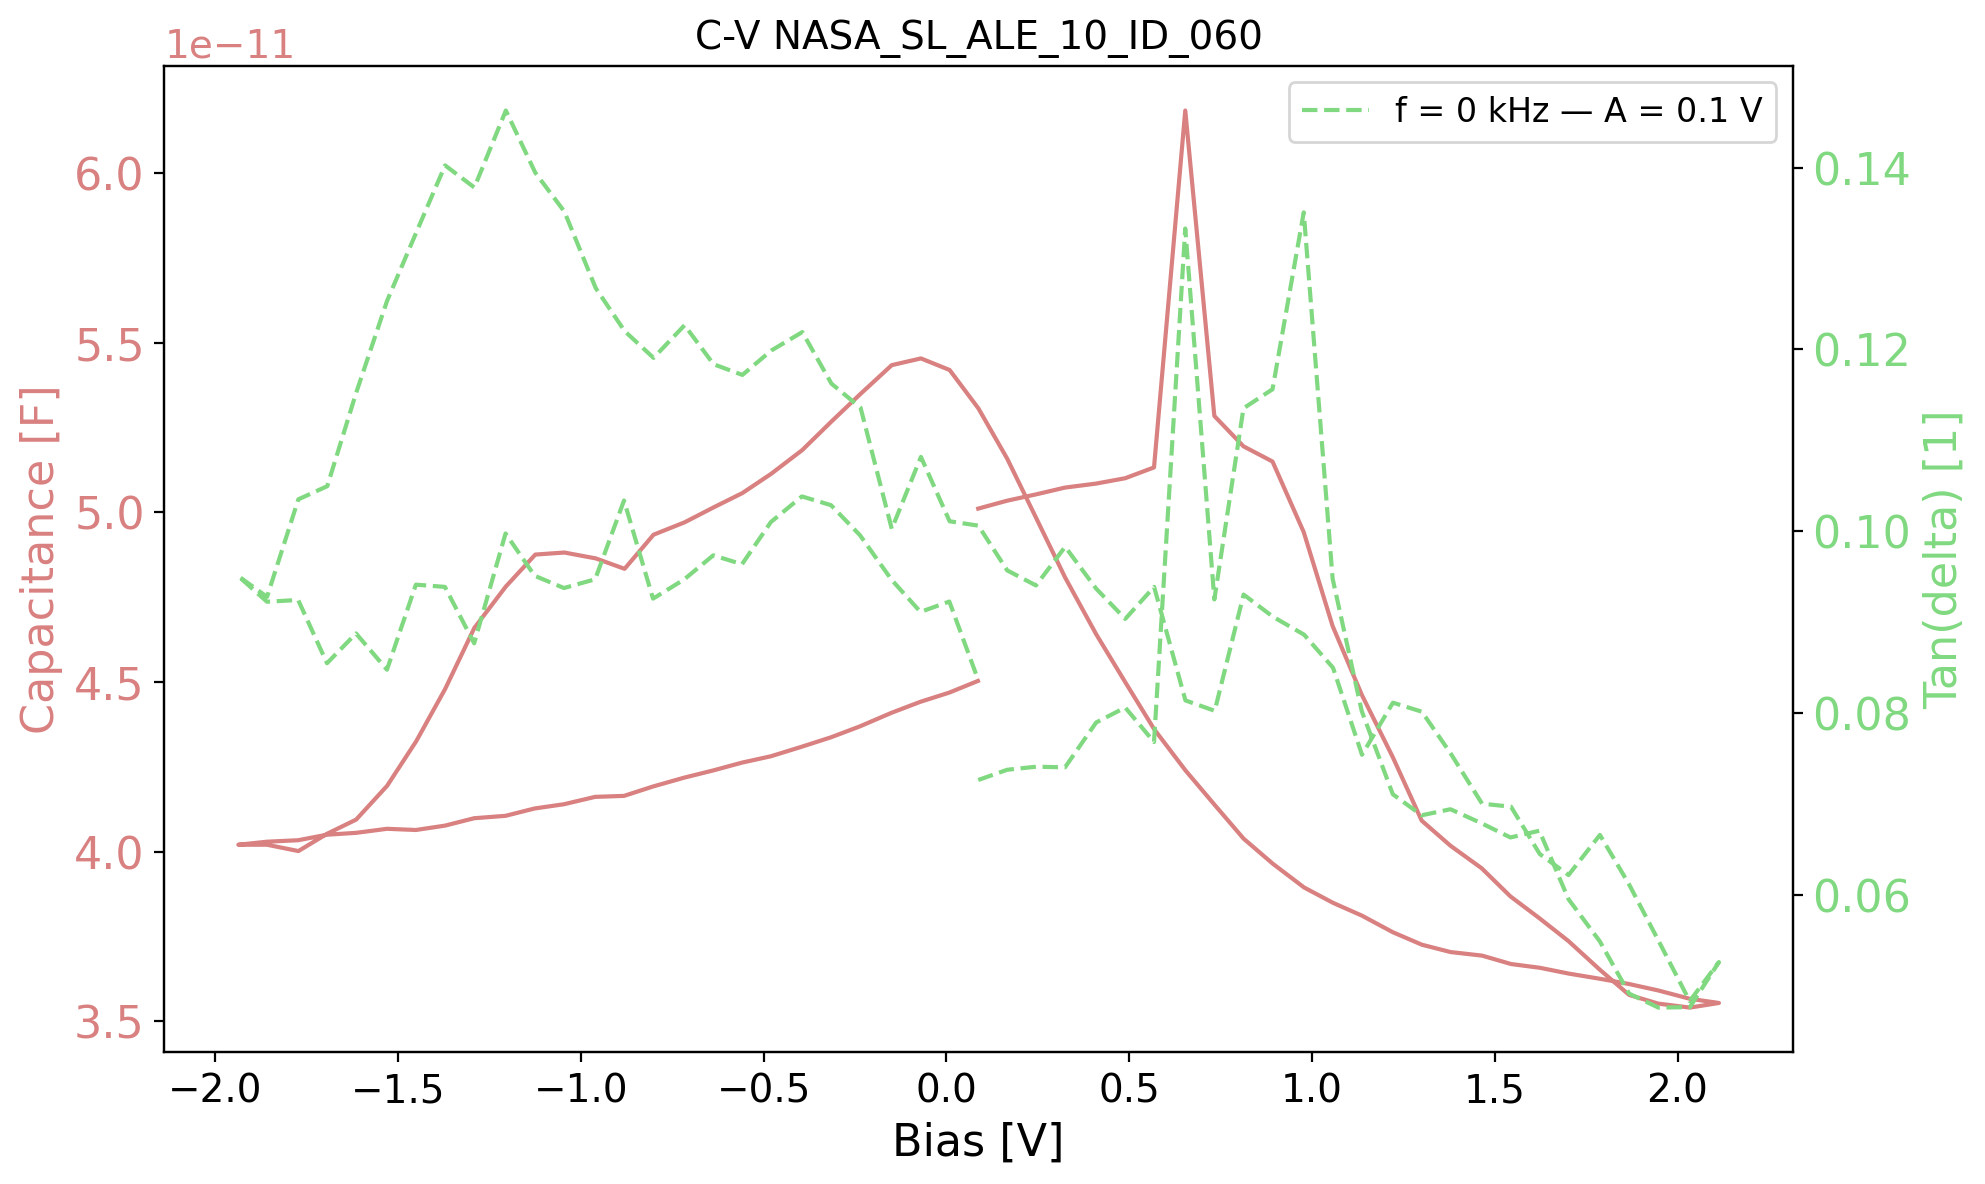

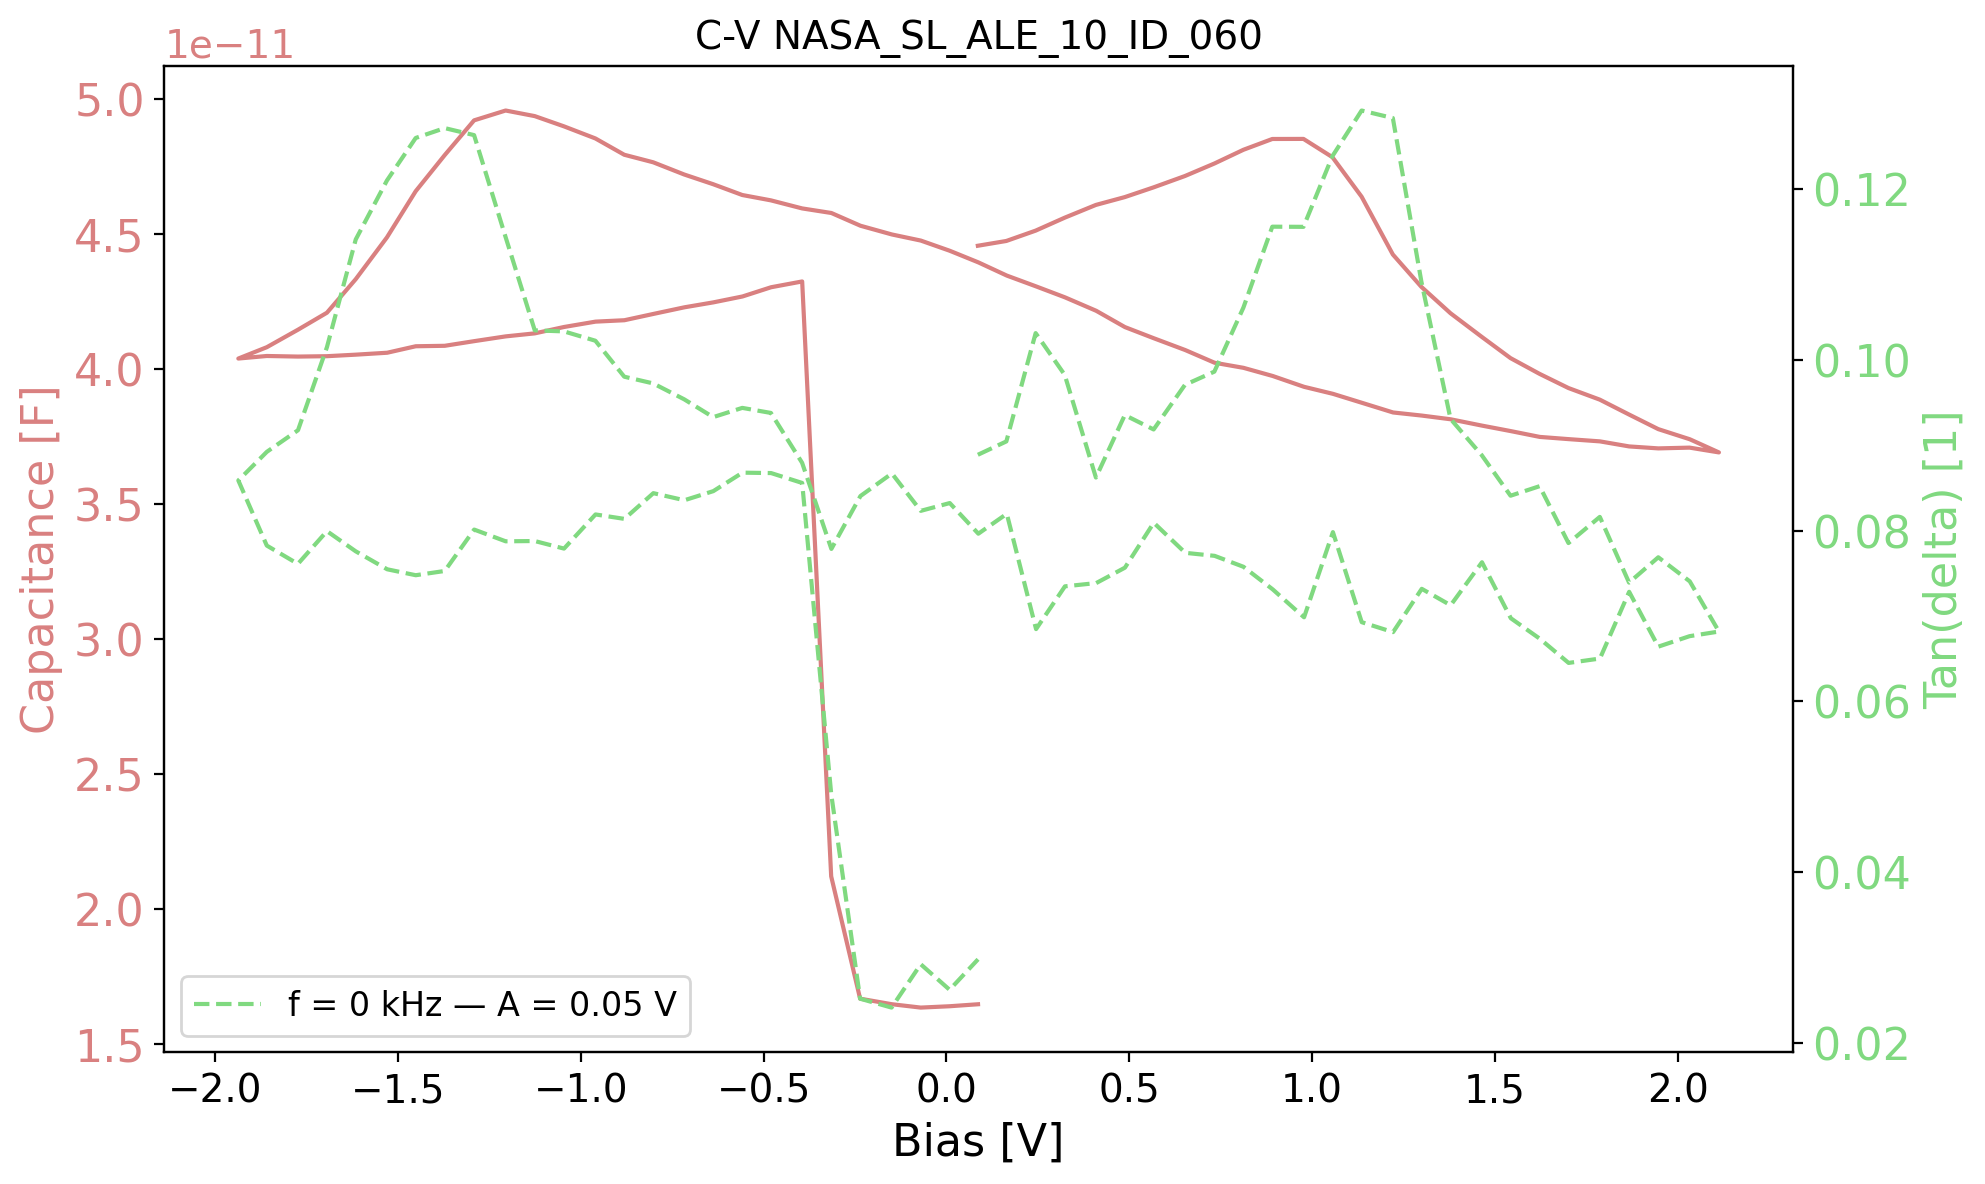

In [12]:
# Plot each table individually with different plots
# ----------------------------------------------------------------------------------------------------------------------------------

color_y1 = (0.5, 0.85, 0.5)  # RGB color for the plot
color_y2 = (0.85, 0.5, 0.5)  # RGB color for the plot

for i, (df, info) in enumerate(zip(dataframes, table_infos)):
    try:
        bias = pd.to_numeric(df['Bias [V]'], errors='coerce')
        cap = pd.to_numeric(df['C [F]'], errors='coerce')
        tan = pd.to_numeric(df['tan(delta) [1]'], errors='coerce') 
        mask = ~bias.isna() & ~cap.isna()

        fig, ax1 = plt.subplots(figsize=(10, 6))

        label_str = f"f = {info['frequency_Hz'] / 1e3:.0f} kHz — A = {info['amplitude_V']} V"

        # Tracer sur le premier axe Y
        ax1.plot(bias, cap, '-', label=label_str, color=color_y2)
        ax1.set_xlabel("Bias [V]",fontsize=16)
        ax1.set_ylabel("Capacitance [F]", color=color_y2,fontsize=16)
        ax1.tick_params(axis='y', labelcolor=color_y2, labelsize=16)

        # Tracer sur le deuxième axe Y
        ax2 = ax1.twinx()
        ax2.plot(bias, tan, '--', label=label_str, color=color_y1)
        ax2.set_ylabel("Tan(delta) [1]", color=color_y1,fontsize=16)
        ax2.tick_params(axis='y', labelcolor= color_y1, labelsize=16)


        plt.legend()
        plt.title(f'C-V {base_name}')
        plt.tight_layout()
        plt.show()

    except KeyError:
        print(f"Colonnes manquantes dans Table {i+1}")
